In [205]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


# df
df = pd.read_csv("ZIONO_weekly_return_detailed.csv")
df.head(22)

df_21 = df[["Close", "Week_Number", "Year"]]
df_21 = df_21[df_21.Year == 2021]

df_22 = df[["Close", "Week_Number", "Year"]]
df_22 = df_22[df_22.Year == 2022]


df_21.head(18)

,Close,Week_Number,Year
5,26.830000,1,2021
6,26.969999,1,2021
7,26.610001,1,2021
8,26.629999,1,2021
9,26.650000,1,2021
10,26.840000,2,2021
11,26.629999,2,2021
12,26.920000,2,2021
13,26.820000,2,2021
14,26.750000,2,2021


In [206]:
df_21_week = df_21.groupby("Week_Number").last()
df_22_week = df_22.groupby("Week_Number").last()
df_21_week.head(8)

,Close,Year
Week_Number,,
1,26.650000,2021
2,26.750000,2021
3,27.780001,2021
4,27.080000,2021
5,27.270000,2021
6,27.120001,2021
7,26.780001,2021
8,26.120001,2021


In [207]:
df_ground_truth = pd.read_csv("ZIONO_weekly_return_volatility.csv")
df_ground_truth.label = df_ground_truth.label.fillna(method='ffill')
df_ground_truth_21 = df_ground_truth[df_ground_truth.Year==2021]

df_ground_truth_21 = df_ground_truth_21.set_index("Week_Number")


df_ground_truth_22 = df_ground_truth[df_ground_truth.Year==2022]
df_ground_truth_22 = df_ground_truth_22.set_index("Week_Number")

df_ground_truth_21.head()

,Year,mean_return,volatility,label
Week_Number,,,,
1,2021,-0.2586,0.729467,green
2,2021,0.0776,0.787634,red
3,2021,0.9710,2.437100,green
4,2021,-0.5042,1.114784,red
5,2021,0.1458,1.217830,green


In [208]:
def get_x_y(df_21_week, W):
    in_df = df_21_week.copy()
    for i in range(W):  # index--0开始，
        real_i = i + 1
        in_df[f"minus_{real_i}"] = in_df.Close.shift(real_i)

    in_df = in_df.iloc[W: , :]

    x = in_df.iloc[:, 2:]
    y = in_df.iloc[:, 0]
    return x, y

def extract_label(x):
#     print(x)
#     print(x.shape)
    if x["pred"] > x["minus_1"]:
        return "green"
    elif x["pred"] < x["minus_1"]:
        return "red"
    else:
        return np.nan


In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

linear_acc = {}
for w in range(5, 13):
    x, y = get_x_y(df_21_week, w)

    # train logistic regression classifier on year 1 data
    lr = LinearRegression()
    lr.fit(x, y)

    # make predictions for year 2 data
    y_pred = lr.predict(x)

    # -1(pW)  -3 -4 -5,  y, y_pred(P* w+1)
    pred_df = pd.concat([x, y], axis = 1)
    pred_df["pred"] = y_pred
    pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

    df_ground_truth_sub = df_ground_truth_21[df_ground_truth_21.index > w]
    pred_df["lable"] = df_ground_truth_sub.label
    pred_df.head()

    accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
#     print("Accuracy for year ", accuracy, " when w=", w)
    linear_acc[w] = accuracy
    
linear_acc

{5: 0.5957446808510638,
 6: 0.5869565217391305,
 7: 0.6,
 8: 0.5909090909090909,
 9: 0.5581395348837209,
 10: 0.5714285714285714,
 11: 0.5853658536585366,
 12: 0.6}

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

quadratic_acc = {}
for w in range(5, 13):
    x, y = get_x_y(df_21_week, w)
    
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
#     print("x_train shape=", X_train.shape, " poly shape=", X_poly_train.shape)

    # train logistic regression classifier on year 1 data
    lr = LinearRegression()
    lr.fit(x_poly, y)

    # make predictions 
    y_pred = lr.predict(x_poly)

    # -1(pW)  -3 -4 -5,  y, y_pred(P* w+1)
    pred_df = pd.concat([x, y], axis = 1)
    pred_df["pred"] = y_pred
    pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

    df_ground_truth_sub = df_ground_truth_21[df_ground_truth_21.index > w]
    pred_df["lable"] = df_ground_truth_sub.label
    pred_df.head()

    accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
#     print("Accuracy for year ", accuracy, " when w=", w)
    quadratic_acc[w] = accuracy
    
quadratic_acc

{5: 0.723404255319149,
 6: 0.7391304347826086,
 7: 0.6,
 8: 0.8863636363636364,
 9: 0.8837209302325582,
 10: 0.8571428571428571,
 11: 0.8536585365853658,
 12: 0.85}

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

cube_acc = {}
for w in range(5, 13):
    x, y = get_x_y(df_21_week, w)
    
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
#     print("x_train shape=", x.shape, " poly shape=", x_poly.shape)

    # train logistic regression classifier on year 1 data
    lr = LinearRegression()
    lr.fit(x_poly, y)

    # make predictions 
    y_pred = lr.predict(x_poly)

    # -1(pW)  -3 -4 -5,  y, y_pred(P* w+1)
    pred_df = pd.concat([x, y], axis = 1)
    pred_df["pred"] = y_pred
    pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

    df_ground_truth_sub = df_ground_truth_21[df_ground_truth_21.index > w]
    pred_df["lable"] = df_ground_truth_sub.label
#     print(pred_df.head())

    accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
#     print("Accuracy for year ", accuracy, " when w=", w)
    cube_acc[w] = accuracy
    
cube_acc

{5: 0.8723404255319149,
 6: 0.8695652173913043,
 7: 0.8666666666666667,
 8: 0.8636363636363636,
 9: 0.8837209302325582,
 10: 0.8571428571428571,
 11: 0.8780487804878049,
 12: 0.85}

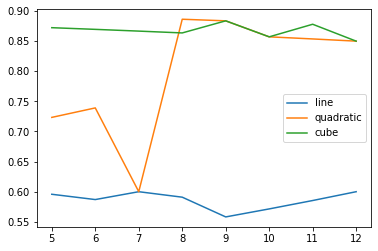

In [212]:
import seaborn as sns

leaner = pd.Series(linear_acc)
qua = pd.Series(quadratic_acc)
cube = pd.Series(cube_acc)
acc_df = pd.DataFrame({"line": leaner, "quadratic":qua, "cube": cube})

acc_df.plot()
plt.show()

In [213]:
acc_df

,line,quadratic,cube
5,0.595745,0.723404,0.872340
6,0.586957,0.739130,0.869565
7,0.600000,0.600000,0.866667
8,0.590909,0.886364,0.863636
9,0.558140,0.883721,0.883721
10,0.571429,0.857143,0.857143
11,0.585366,0.853659,0.878049
12,0.600000,0.850000,0.850000


In [214]:
# 2--li
acc_df.idxmax()

line         7
quadratic    8
cube         9
dtype: int64

In [215]:
# 2 linear -- 7

w = 7
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
lr = LinearRegression()
lr.fit(x, y)



x, y = get_x_y(df_22_week, w)
y_pred = lr.predict(x)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
print("Linear Accuracy for year 22 ", accuracy, " when w=", w)


Linear Accuracy for year 22  0.5333333333333333  when w= 7


In [216]:
# 2 quadratic    8

w = 8
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)



x, y = get_x_y(df_22_week, w)
x_poly = poly.fit_transform(x)
y_pred = lr.predict(x_poly)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
print("quadratic Accuracy for year 22 ", accuracy, " when w=", w)

quadratic Accuracy for year 22  0.45454545454545453  when w= 8


In [217]:
# 2 cube 9

w = 9
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)



x, y = get_x_y(df_22_week, w)
x_poly = poly.fit_transform(x)
y_pred = lr.predict(x_poly)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

accuracy = accuracy_score(pred_df["lable"], pred_df["pred_label"])
print("quadratic Accuracy for year 22 ", accuracy, " when w=", w)

quadratic Accuracy for year 22  0.5348837209302325  when w= 9


In [218]:
# 3

# 2 linear -- 7

w = 7
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
lr = LinearRegression()
lr.fit(x, y)



x, y = get_x_y(df_22_week, w)
y_pred = lr.predict(x)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

conf = confusion_matrix(pred_df["lable"], pred_df["pred_label"])
print("Linear conf for year 22 \n", conf, " \n when w=", w)


Linear conf for year 22 
 [[24  0]
 [21  0]]  
 when w= 7


In [220]:
# 3 quadratic    8

w = 8
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)



x, y = get_x_y(df_22_week, w)
x_poly = poly.fit_transform(x)
y_pred = lr.predict(x_poly)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

conf = confusion_matrix(pred_df["lable"], pred_df["pred_label"])
print("quadratic confusion_matrix for year 22 \n", conf, " \n when w=", w)

quadratic confusion_matrix for year 22 
 [[ 0 24]
 [ 0 20]]  
 when w= 8


In [222]:
# 3 cube    9

w = 9
x, y = get_x_y(df_21_week, w)

# train logistic regression classifier on year 1 data
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)



x, y = get_x_y(df_22_week, w)
x_poly = poly.fit_transform(x)
y_pred = lr.predict(x_poly)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["pred_label"] = pred_df.apply(extract_label, axis=1)

df_ground_truth_sub = df_ground_truth_22[df_ground_truth_22.index > w]
pred_df["lable"] = df_ground_truth_sub.label
pred_df.head()

conf = confusion_matrix(pred_df["lable"], pred_df["pred_label"])
print("quadratic confusion_matrix for year 22 \n", conf, " \n when w=", w)

quadratic confusion_matrix for year 22 
 [[23  0]
 [20  0]]  
 when w= 9
